In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import warnings
warnings.filterwarnings("ignore")

In [4]:

print("="*70)
print("BRAIN REGION CLASSIFICATION: PIOP-2 → PIOP-1")
print("="*70)

# ============================================================================
# STEP 1: Train Model on PIOP-2 (Resting-State)
# ============================================================================
print("\n[1/5] Loading PIOP-2 (Resting-State) data...")

df_piop2 = pd.read_csv('../data/raw/PIOP2_restingstate.csv')
connection_columns = df_piop2.columns[1:].tolist()

# Extract unique regions from column names
unique_regions = set()
for col in connection_columns:
    regions = col.split('~')
    if len(regions) == 2:
        unique_regions.add(regions[0])
        unique_regions.add(regions[1])

region_list = sorted(list(unique_regions))
n_regions = len(region_list)
region_to_idx = {region: idx for idx, region in enumerate(region_list)}

print(f"   • Subjects: {df_piop2.shape[0]}")
print(f"   • Brain regions: {n_regions}")
print(f"   • Connections: {len(connection_columns)}")

# Function to reconstruct connectivity matrix from row data
def reconstruct_matrix(row_data, connection_columns, region_to_idx, n_regions):
    matrix = np.zeros((n_regions, n_regions))
    for col_name, value in zip(connection_columns, row_data):
        regions = col_name.split('~')
        if len(regions) == 2:
            idx1 = region_to_idx[regions[0]]
            idx2 = region_to_idx[regions[1]]
            matrix[idx1, idx2] = value
            matrix[idx2, idx1] = value
    np.fill_diagonal(matrix, 1.0)
    return matrix

# Create training dataset
print("\n[2/5] Creating training dataset from PIOP-2...")

X_train_list = []
y_train_list = []

for subject_idx in range(df_piop2.shape[0]):
    connectivity_values = df_piop2.iloc[subject_idx, 1:].values
    conn_matrix = reconstruct_matrix(connectivity_values, connection_columns, region_to_idx, n_regions)
    
    # Extract each region's connectivity pattern (excluding self-connection)
    for region_idx in range(n_regions):
        connectivity_pattern = conn_matrix[region_idx, :].copy()
        connectivity_pattern = np.delete(connectivity_pattern, region_idx)  # Remove diagonal
        X_train_list.append(connectivity_pattern)
        y_train_list.append(region_idx)

X_train = np.array(X_train_list)
y_train = np.array(y_train_list)

print(f"   • Training samples: {X_train.shape[0]}")
print(f"   • Features per sample: {X_train.shape[1]}")

# Train the model
print("\n[3/5] Training Logistic Regression model...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

model = LogisticRegression(
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    n_jobs=-1,
    C=0.1
)

model.fit(X_train_scaled, y_train)

# Evaluate on training data (baseline)
y_train_pred = model.predict(X_train_scaled)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"   • Training accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")


BRAIN REGION CLASSIFICATION: PIOP-2 → PIOP-1

[1/5] Loading PIOP-2 (Resting-State) data...
   • Subjects: 224
   • Brain regions: 232
   • Connections: 26796

[2/5] Creating training dataset from PIOP-2...
   • Training samples: 51968
   • Features per sample: 231

[3/5] Training Logistic Regression model...
   • Training accuracy: 0.9201 (92.01%)


In [5]:
# ============================================================================
# STEP 2: Apply Model to PIOP-1 (Task Data)
# ============================================================================
print("\n[4/5] Applying model to PIOP-1 (Gender Task) data...")

df_piop1 = pd.read_csv('../data/raw/PIOP1_gstroop.csv')
print(f"   • PIOP-1 subjects: {df_piop1.shape[0]}")

# Verify column structure matches
assert df_piop1.columns[1:].tolist() == connection_columns, "Column mismatch!"
print(f"   ✓ Column structure matches PIOP-2")

# Create test dataset
X_test_list = []
y_test_list = []
subject_ids = []

for subject_idx in range(df_piop1.shape[0]):
    subject_id = df_piop1.iloc[subject_idx, 0]
    connectivity_values = df_piop1.iloc[subject_idx, 1:].values
    conn_matrix = reconstruct_matrix(connectivity_values, connection_columns, region_to_idx, n_regions)
    
    for region_idx in range(n_regions):
        connectivity_pattern = conn_matrix[region_idx, :].copy()
        connectivity_pattern = np.delete(connectivity_pattern, region_idx)
        X_test_list.append(connectivity_pattern)
        y_test_list.append(region_idx)
        subject_ids.append(subject_id)

X_test = np.array(X_test_list)
y_test = np.array(y_test_list)
subject_ids = np.array(subject_ids)

print(f"   • Test samples: {X_test.shape[0]}")

# Apply model
X_test_scaled = scaler.transform(X_test)
y_test_pred = model.predict(X_test_scaled)

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"   • Test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"   • Accuracy drop: {(train_accuracy - test_accuracy)*100:.2f}%")


[4/5] Applying model to PIOP-1 (Gender Task) data...
   • PIOP-1 subjects: 200
   ✓ Column structure matches PIOP-2
   • Test samples: 46400
   • Test accuracy: 0.6970 (69.70%)
   • Accuracy drop: 22.30%


In [ ]:
# ============================================================================
# STEP 3: Create Error Map - Which Regions Were Misclassified
# ============================================================================
print("\n[5/5] Creating Error Map...")

# Calculate per-region misclassification rate
misclassification_rate = np.zeros(n_regions)

for region_idx in range(n_regions):
    region_mask = y_test == region_idx
    y_true_region = y_test[region_mask]
    y_pred_region = y_test_pred[region_mask]
    
    # Misclassification rate = 1 - accuracy
    misclassification_rate[region_idx] = 1 - accuracy_score(y_true_region, y_pred_region)

# Sort regions by misclassification rate
sorted_indices = np.argsort(misclassification_rate)[::-1]


[5/5] Creating Error Map...


In [ ]:

# Display Results
# ============================================================================
print("\n" + "="*70)
print("ERROR MAP: TOP 30 MISCLASSIFIED REGIONS")
print("="*70)
print(f"{'Rank':<6} {'Region Name':<55} {'Error Rate':<12} {'Samples':<10}")
print("-"*90)

for rank, region_idx in enumerate(sorted_indices[:30], 1):
    region_name = region_list[region_idx]
    error_rate = misclassification_rate[region_idx]
    n_samples = (y_test == region_idx).sum()
    
    # Color coding
    if error_rate > 0.5:
        marker = "🔴"
    elif error_rate > 0.3:
        marker = "🟡"
    else:
        marker = "🟢"
    
    print(f"{rank:<6} {region_name:<55} {error_rate:.4f} {marker:<6} {n_samples:<10}")

print("\n" + "="*70)
print("ERROR MAP: 30 BEST CLASSIFIED REGIONS")
print("="*70)
print(f"{'Rank':<6} {'Region Name':<55} {'Error Rate':<12} {'Samples':<10}")
print("-"*90)

for rank, region_idx in enumerate(sorted_indices[-30:][::-1], 1):
    region_name = region_list[region_idx]
    error_rate = misclassification_rate[region_idx]
    n_samples = (y_test == region_idx).sum()
    print(f"{rank:<6} {region_name:<55} {error_rate:.4f} ✅     {n_samples:<10}")

# Summary statistics
print("\n" + "="*70)
print("SUMMARY STATISTICS")
print("="*70)
print(f"Total brain regions:              {n_regions}")
print(f"Mean misclassification rate:      {misclassification_rate.mean():.4f} ({misclassification_rate.mean()*100:.2f}%)")
print(f"Median misclassification rate:    {np.median(misclassification_rate):.4f}")
print(f"Std misclassification rate:       {misclassification_rate.std():.4f}")
print(f"Min misclassification rate:       {misclassification_rate.min():.4f}")
print(f"Max misclassification rate:       {misclassification_rate.max():.4f}")
print(f"\nRegions with high error (>30%):   {(misclassification_rate > 0.3).sum()} / {n_regions}")
print(f"Regions with low error (<10%):    {(misclassification_rate < 0.1).sum()} / {n_regions}")



ERROR MAP: TOP 30 MISCLASSIFIED REGIONS
Rank   Region Name                                             Error Rate   Samples   
------------------------------------------------------------------------------------------
1      mAMY-rh                                                 0.7250 🔴      200       
2      aGP-rh                                                  0.7100 🔴      200       
3      aGP-lh                                                  0.7050 🔴      200       
4      RH_SomMotB_S2_1                                         0.6550 🔴      200       
5      NAc-shell-lh                                            0.6350 🔴      200       
6      pGP-lh                                                  0.6300 🔴      200       
7      THA-DP-rh                                               0.6100 🔴      200       
8      lAMY-rh                                                 0.5900 🔴      200       
9      pGP-rh                                                  0.5850 🔴      


GENERATING ERROR MAP VISUALIZATIONS
✓ Saved: error_map_piop1.png
✓ Saved: error_map_heatmap_piop1.png


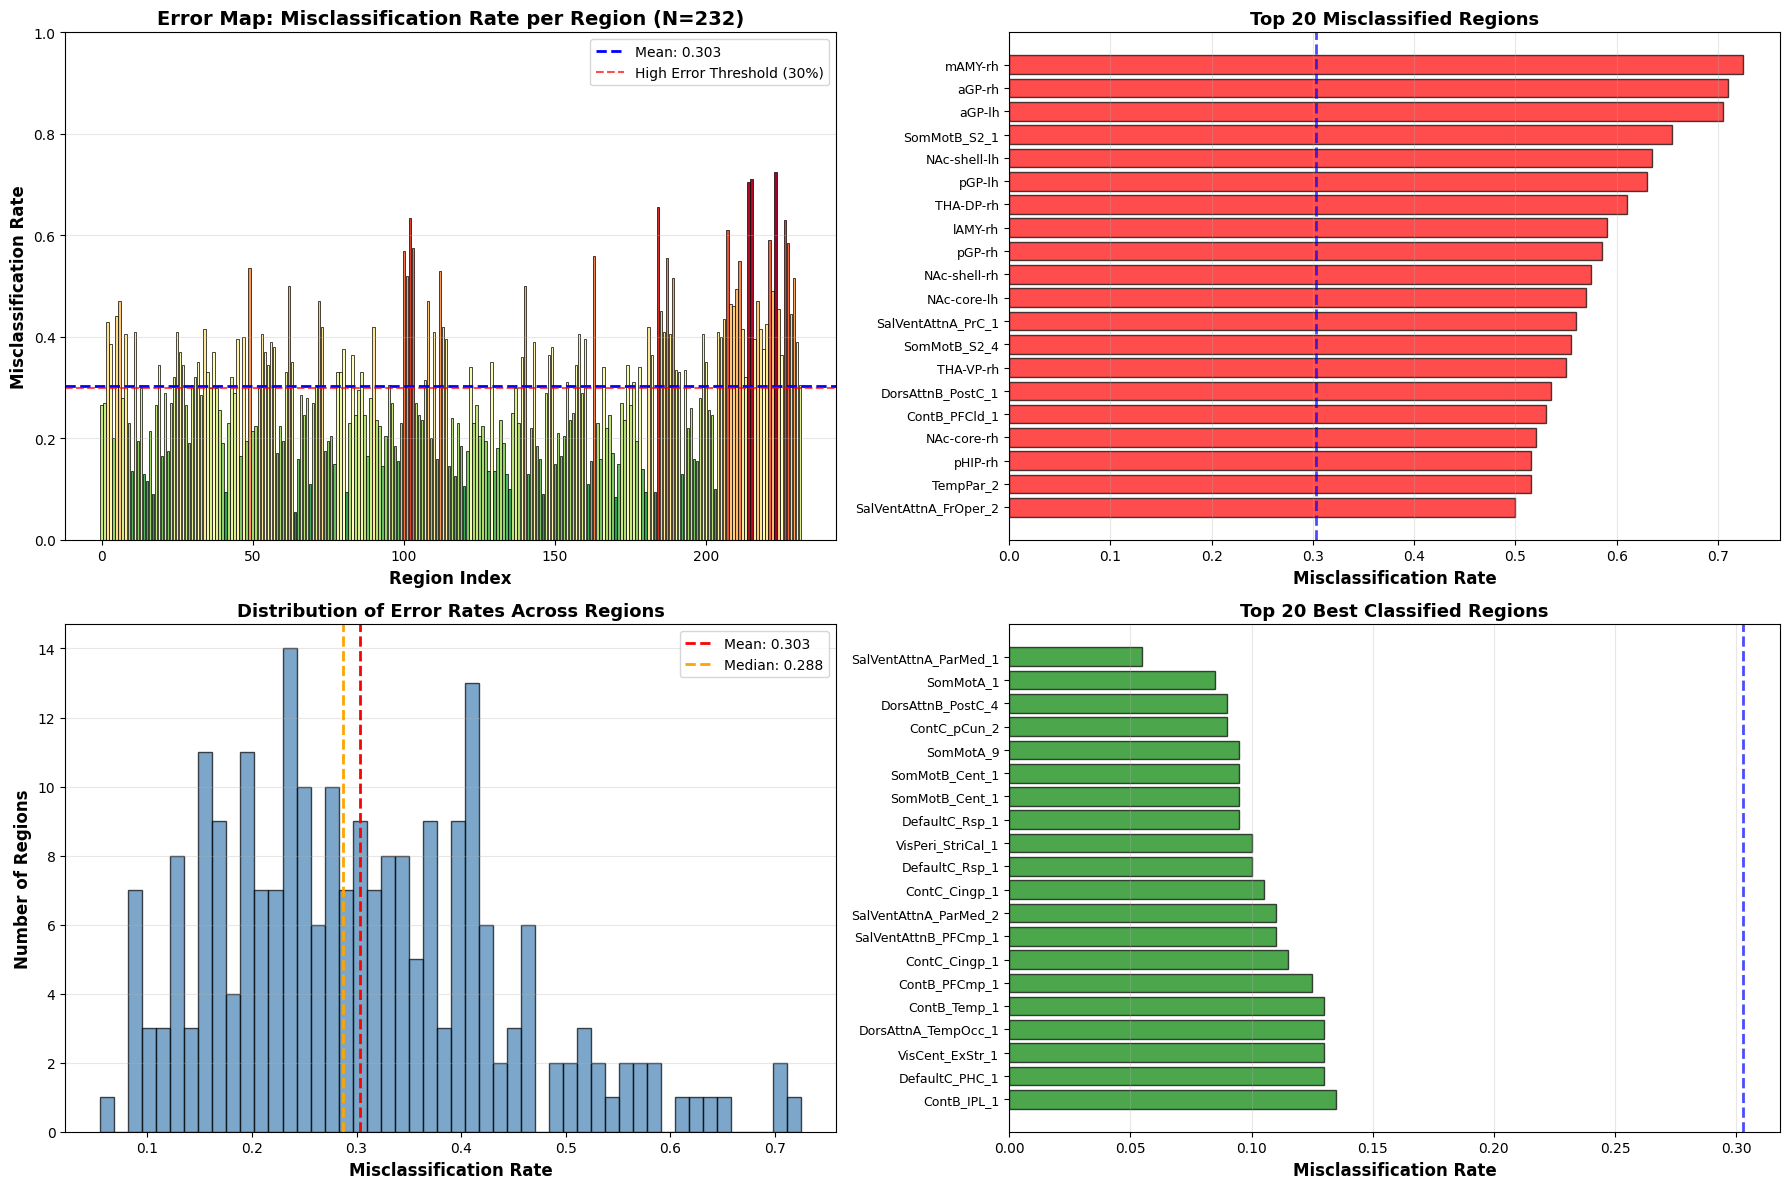

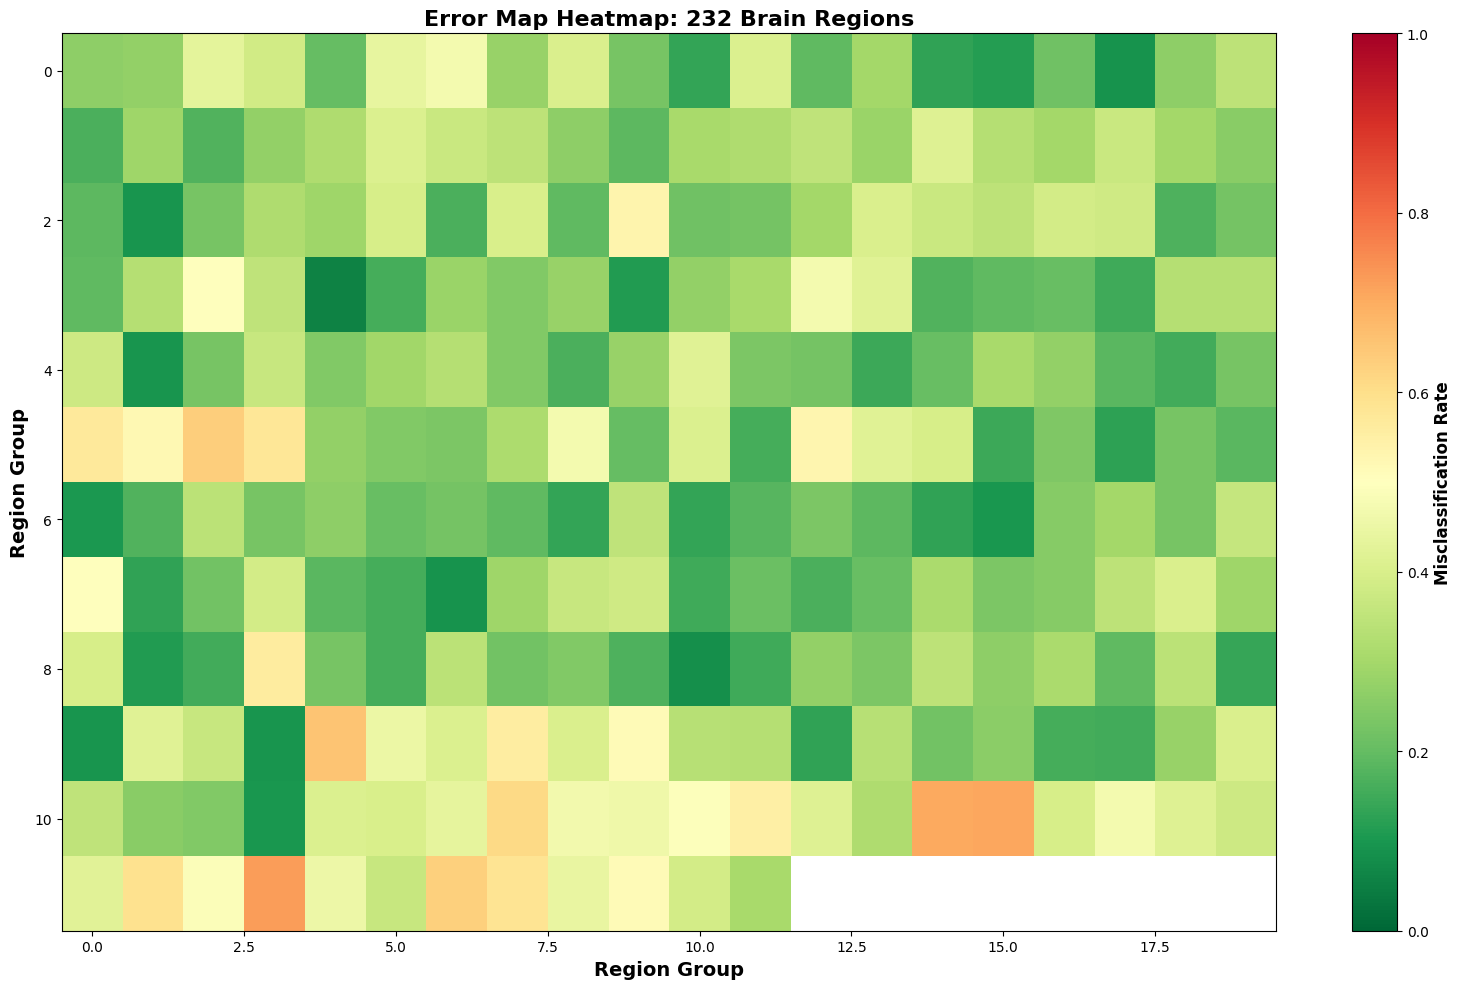

In [ ]:

# Visualizations - Error Map
# ============================================================================
print("\n" + "="*70)
print("GENERATING ERROR MAP VISUALIZATIONS")
print("="*70)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Error map - all regions
ax1 = axes[0, 0]
colors = plt.cm.RdYlGn_r(misclassification_rate / misclassification_rate.max())
bars = ax1.bar(range(n_regions), misclassification_rate, color=colors, edgecolor='black', linewidth=0.5)
ax1.axhline(misclassification_rate.mean(), color='blue', linestyle='--', linewidth=2, label=f'Mean: {misclassification_rate.mean():.3f}')
ax1.axhline(0.3, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='High Error Threshold (30%)')
ax1.set_xlabel('Region Index', fontsize=12, fontweight='bold')
ax1.set_ylabel('Misclassification Rate', fontsize=12, fontweight='bold')
ax1.set_title(f'Error Map: Misclassification Rate per Region (N={n_regions})', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])

# Plot 2: Top 20 worst classified regions
ax2 = axes[0, 1]
top_20_worst = sorted_indices[:20]
region_names_worst = [region_list[i].replace('LH_', '').replace('RH_', '')[:35] for i in top_20_worst]
errors_worst = misclassification_rate[top_20_worst]

bars2 = ax2.barh(range(20), errors_worst, color='red', alpha=0.7, edgecolor='black')
ax2.set_yticks(range(20))
ax2.set_yticklabels(region_names_worst, fontsize=9)
ax2.set_xlabel('Misclassification Rate', fontsize=12, fontweight='bold')
ax2.set_title('Top 20 Misclassified Regions', fontsize=13, fontweight='bold')
ax2.axvline(misclassification_rate.mean(), color='blue', linestyle='--', linewidth=2, alpha=0.7)
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

# Plot 3: Distribution of error rates
ax3 = axes[1, 0]
ax3.hist(misclassification_rate, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
ax3.axvline(misclassification_rate.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {misclassification_rate.mean():.3f}')
ax3.axvline(np.median(misclassification_rate), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(misclassification_rate):.3f}')
ax3.set_xlabel('Misclassification Rate', fontsize=12, fontweight='bold')
ax3.set_ylabel('Number of Regions', fontsize=12, fontweight='bold')
ax3.set_title('Distribution of Error Rates Across Regions', fontsize=13, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Top 20 best classified regions
ax4 = axes[1, 1]
top_20_best = sorted_indices[-20:][::-1]
region_names_best = [region_list[i].replace('LH_', '').replace('RH_', '')[:35] for i in top_20_best]
errors_best = misclassification_rate[top_20_best]

bars4 = ax4.barh(range(20), errors_best, color='green', alpha=0.7, edgecolor='black')
ax4.set_yticks(range(20))
ax4.set_yticklabels(region_names_best, fontsize=9)
ax4.set_xlabel('Misclassification Rate', fontsize=12, fontweight='bold')
ax4.set_title('Top 20 Best Classified Regions', fontsize=13, fontweight='bold')
ax4.axvline(misclassification_rate.mean(), color='blue', linestyle='--', linewidth=2, alpha=0.7)
ax4.grid(axis='x', alpha=0.3)
ax4.invert_yaxis()

plt.tight_layout()
plt.savefig('error_map_piop1.png', dpi=300, bbox_inches='tight')
print(" Saved: error_map_piop1.png")

# Heatmap-style error map
# ============================================================================
fig2, ax = plt.subplots(1, 1, figsize=(16, 10))

# Reshape error rates into a grid for better visualization
n_cols = 20
n_rows = int(np.ceil(n_regions / n_cols))
error_grid = np.zeros((n_rows, n_cols))
error_grid.fill(np.nan)

for idx, region_idx in enumerate(range(n_regions)):
    row = idx // n_cols
    col = idx % n_cols
    error_grid[row, col] = misclassification_rate[region_idx]

im = ax.imshow(error_grid, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=1)
ax.set_xlabel('Region Group', fontsize=14, fontweight='bold')
ax.set_ylabel('Region Group', fontsize=14, fontweight='bold')
ax.set_title(f'Error Map Heatmap: {n_regions} Brain Regions', fontsize=16, fontweight='bold')

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Misclassification Rate', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('error_map_heatmap_piop1.png', dpi=300, bbox_inches='tight')
print("✓ Saved: error_map_heatmap_piop1.png")

In [ ]:

# Save error map to CSV
error_map_df = pd.DataFrame({
    'region_index': range(n_regions),
    'region_name': region_list,
    'misclassification_rate': misclassification_rate,
    'n_samples': [((y_test == i).sum()) for i in range(n_regions)]
})

error_map_df = error_map_df.sort_values('misclassification_rate', ascending=False)
error_map_df.to_csv('error_map_piop1.csv', index=False)
print("✓ Saved: error_map_piop1.csv")

print("\n" + "="*70)
print(" ANALYSIS COMPLETE!")
print("="*70)
print(f"\n Results:")
print(f"   • {(misclassification_rate > 0.3).sum()} regions show high error (>30%)")
print(f"   • These regions have altered connectivity during gender task")

print(f"\n Output files:")
print(f"   1. error_map_piop1.png - Main visualization")
print(f"   2. error_map_heatmap_piop1.png - Heatmap view")
print(f"   3. error_map_piop1.csv - Complete data table")

✓ Saved: error_map_piop1.csv

✅ ANALYSIS COMPLETE!

📊 Results:
   • 111 regions show high error (>30%)
   • These regions have altered connectivity during gender task
   • Check visualizations and CSV file for detailed error map

📁 Output files:
   1. error_map_piop1.png - Main visualization
   2. error_map_heatmap_piop1.png - Heatmap view
   3. error_map_piop1.csv - Complete data table
